In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
# Load the training and testing datasets
train_essays = pd.read_csv("../data/train_essays.csv")
test_essays = pd.read_csv("../data/test_essays.csv")

In [3]:
# Explore the training data
train_essays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


In [4]:
train_essays.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


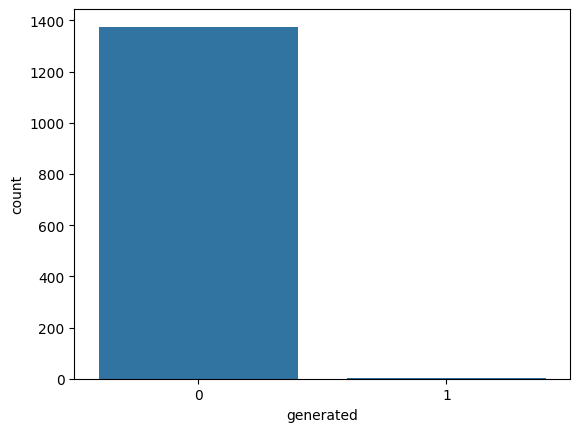

In [5]:
# Check for class balance
sns.countplot(data=train_essays, x='generated')
plt.show()

In [6]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    words = text.split()  # Tokenize
    words = [word.lower() for word in words if word.isalpha()]  # Lowercase and remove non-alphabetic words
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

train_essays['clean_text'] = train_essays['text'].apply(clean_text)

In [7]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_essays['clean_text'], train_essays['generated'], test_size=0.2, random_state=42)

In [8]:
# Tokenization and Encoding for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, padding=True, truncation=True, max_length=128)

In [9]:
encoded_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')
encoded_val = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='pt')

In [10]:
# Convert labels to tensors
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)

In [11]:
# Create TensorDatasets
train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], train_labels)
val_dataset = TensorDataset(encoded_val['input_ids'], encoded_val['attention_mask'], val_labels)

In [12]:
# DataLoader for efficient processing
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False, num_workers=8, pin_memory=True)

In [13]:
from transformers import logging
logging.set_verbosity_error()
# Define the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [14]:
# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False, no_deprecation_warning=True)
epochs = 10

In [16]:
# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping to avoid exploding gradients
        optimizer.step()
        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.2f}")

KeyboardInterrupt: 

In [ ]:
# Validation loop
model.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

In [ ]:
# Calculate validation accuracy
val_accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {val_accuracy:.2f}")

In [ ]:
# Test data processing
test_inputs = tokenizer(test_essays['text'].tolist(), padding=True, truncation=True, return_tensors='pt')

# Move input tensor to the same device as the model
test_inputs = {key: value.to(device) for key, value in test_inputs.items()}

# Generate predictions using your trained model
with torch.no_grad():
    outputs = model(**test_inputs)
    logits = outputs.logits

# Assuming the first column of logits corresponds to the negative class (non-AI-generated) 
# and the second column corresponds to the positive class (AI-generated)
predictions = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # Move predictions back to CPU

# Create a submission DataFrame with essay IDs and corresponding predictions
submission = pd.DataFrame({
    'id': test_essays['id'],
    'generated': predictions
})

# Save the submission DataFrame to a CSV file
submission.to_csv('/kaggle/working/submission.csv', index=False)